# The goal is to study the induction head in GPT-2 

## This notebook is based on clean-up of "preliminary_analysis.ipynb"

**Author: Yiqiao Zhong**

**Dec 18, 2023**

In [2]:
import torch
import numpy as np
import os
import math
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import seaborn as sns
from torch.nn import functional as F

from transformers import logging
from transformers import set_seed
from transformers import GPT2Model, GPT2Config
from transformers import GPT2Tokenizer
np.set_printoptions(precision=4)

set_seed(2024)

logging.set_verbosity_error()
def create_folder(dir):
    if not os.path.isdir(dir):
        os.mkdir(dir)

## Table of contents:
- [Simple visualization](#simple-visualization)
  * [Calulating embeddings and matrices](#calulating-embeddings-and-matrices)
  * [Attention and weight visualization](#attention-and-weight-visualization)
  * [Embeddings across layers](#embeddings-across-layers)
- [Matching weight matrices](#maching-weight-matrices)
  * [Matching QK and OV](#matching-qk-and-ov)
  * [Matching OV and wte](#matching-ov-and-wte)
  * [QK subspace universality](#qk-subspace-universality)
  * [OV subspace universality](#ov-subspace-universality)
- [Intervention experiments](#intervention-experiments)

## Simple visualization

### Calulating embeddings and matrices

### Step 1-1-1: loading GPT-2 and setting global variables

In [3]:
configuration = GPT2Config()
model = GPT2Model.from_pretrained("gpt2", output_attentions=True)
configuration = model.config
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
vocab_size = 50257
T0 = 5

sample_int = np.random.randint(low=0,high=vocab_size,size=T0).repeat(3).reshape(T0,-1).T.ravel()
input_ids = torch.Tensor(sample_int).long().unsqueeze(0)

with torch.no_grad():
    output = model(input_ids) # (num_layer, num_head, seq_length, seq_length) = (12, 12, 15, 15)
len(output.attentions), output.attentions[0].size()

attentions = np.array([a.detach().numpy()[0] for a in output.attentions])
attentions.shape

(12, 12, 15, 15)

### Step 1-1-2: Calculating embeddings for each sublayer

In [17]:
num_layer = 12
num_heads = 12
d_model = 768
d_head = d_model // num_heads
seq_len = input_ids.size(1)

model.eval()

hiddens_all = torch.zeros(num_layer+1, 6, seq_len, d_model)

h = model.wte(input_ids)
pos = torch.arange(0, seq_len, dtype=torch.long).unsqueeze(0)
h = model.drop(model.wte(input_ids) + model.wpe(pos))
hiddens_all[0] = h.squeeze()
for layer in range(num_layer):
    h2 = model.h[layer].ln_1(h) # LayerNorm_1 output embeddings, (seq_length, d_model)
    h4 = model.h[layer].attn(h2)[0]  # Self-attention output embeddings (seq_length, d_model)
    h5 = h + h4 # Adding with identity component, (seq_length, d_model)
    h6 = model.h[layer].ln_2(h5) # LayerNorm_2 output embeddings, (seq_length, d_model)
    h = model.h[layer](h)[0] # Next-layer embeddings, (seq_length, d_model)

    hiddens_all[layer+1, 0] = h.squeeze() 
    hiddens_all[layer, 1] = h2.squeeze() 
    # hiddens_all[layer, 2] = torch.tensor(attentions[layer,layer,:,:]) @ h2.squeeze()  # NOT CORRECT
    hiddens_all[layer, 3] = h4.squeeze() 
    hiddens_all[layer, 4] = h5.squeeze() 
    hiddens_all[layer, 5] = h6.squeeze()    
    
def cosine_sim(x, y, prec_digit=4):
    x, y = torch.tensor(x), torch.tensor(y)
    out = torch.sum(x * y) / (torch.norm(x) * torch.norm(y))
    return np.around(out.numpy(force=True), decimals=prec_digit)

def matrix_mask(d, return_one=True, offsets=[0]):
    offsets = [torch.tensor(offset) for offset in offsets]
    mask = torch.zeros(d, d, dtype=torch.bool)
    for offset in offsets:
        mask += torch.diag(torch.ones(d-torch.abs(offset), dtype=torch.bool), offset)
    mask = mask if return_one else ~mask
    return mask


### Step 1-1-3: Calculating QK and OV matrices for all layers

In [23]:
W0 = model.wte.weight
vals_flip, vecs_flip = np.linalg.eigh((W0.T @ W0).numpy(force=True))
vals, vecs = vals_flip[::-1], vecs_flip[:,::-1]

W_all = torch.zeros(num_layer, num_heads, 4, d_model, d_head)

for layer in range(num_layer):
    W_q, W_k, W_v = model.h[layer].attn.c_attn.weight.split(d_model, dim=1)
    W_q = W_q.view(d_model, num_heads, d_model//num_heads)
    W_k = W_k.view(d_model, num_heads, d_model//num_heads)
    W_v = W_v.view(d_model, num_heads, d_model//num_heads)
    W_o = model.h[layer].attn.c_proj.weight.view(num_heads, d_model//num_heads, d_model)
    
    for head in range(num_heads): 
        W_all[layer, head, 0] = W_q[:,head,:] # (d_model, d_head)
        W_all[layer, head, 1] = W_k[:,head,:] # (d_model, d_head)
        W_all[layer, head, 2] = W_v[:,head,:] # (d_model, d_head)
        W_all[layer, head, 3] = W_o[head,:,:].T # (d_model, d_head)

## Attention and weight visualization

### Step 1-2-1: visualize the attention matrices

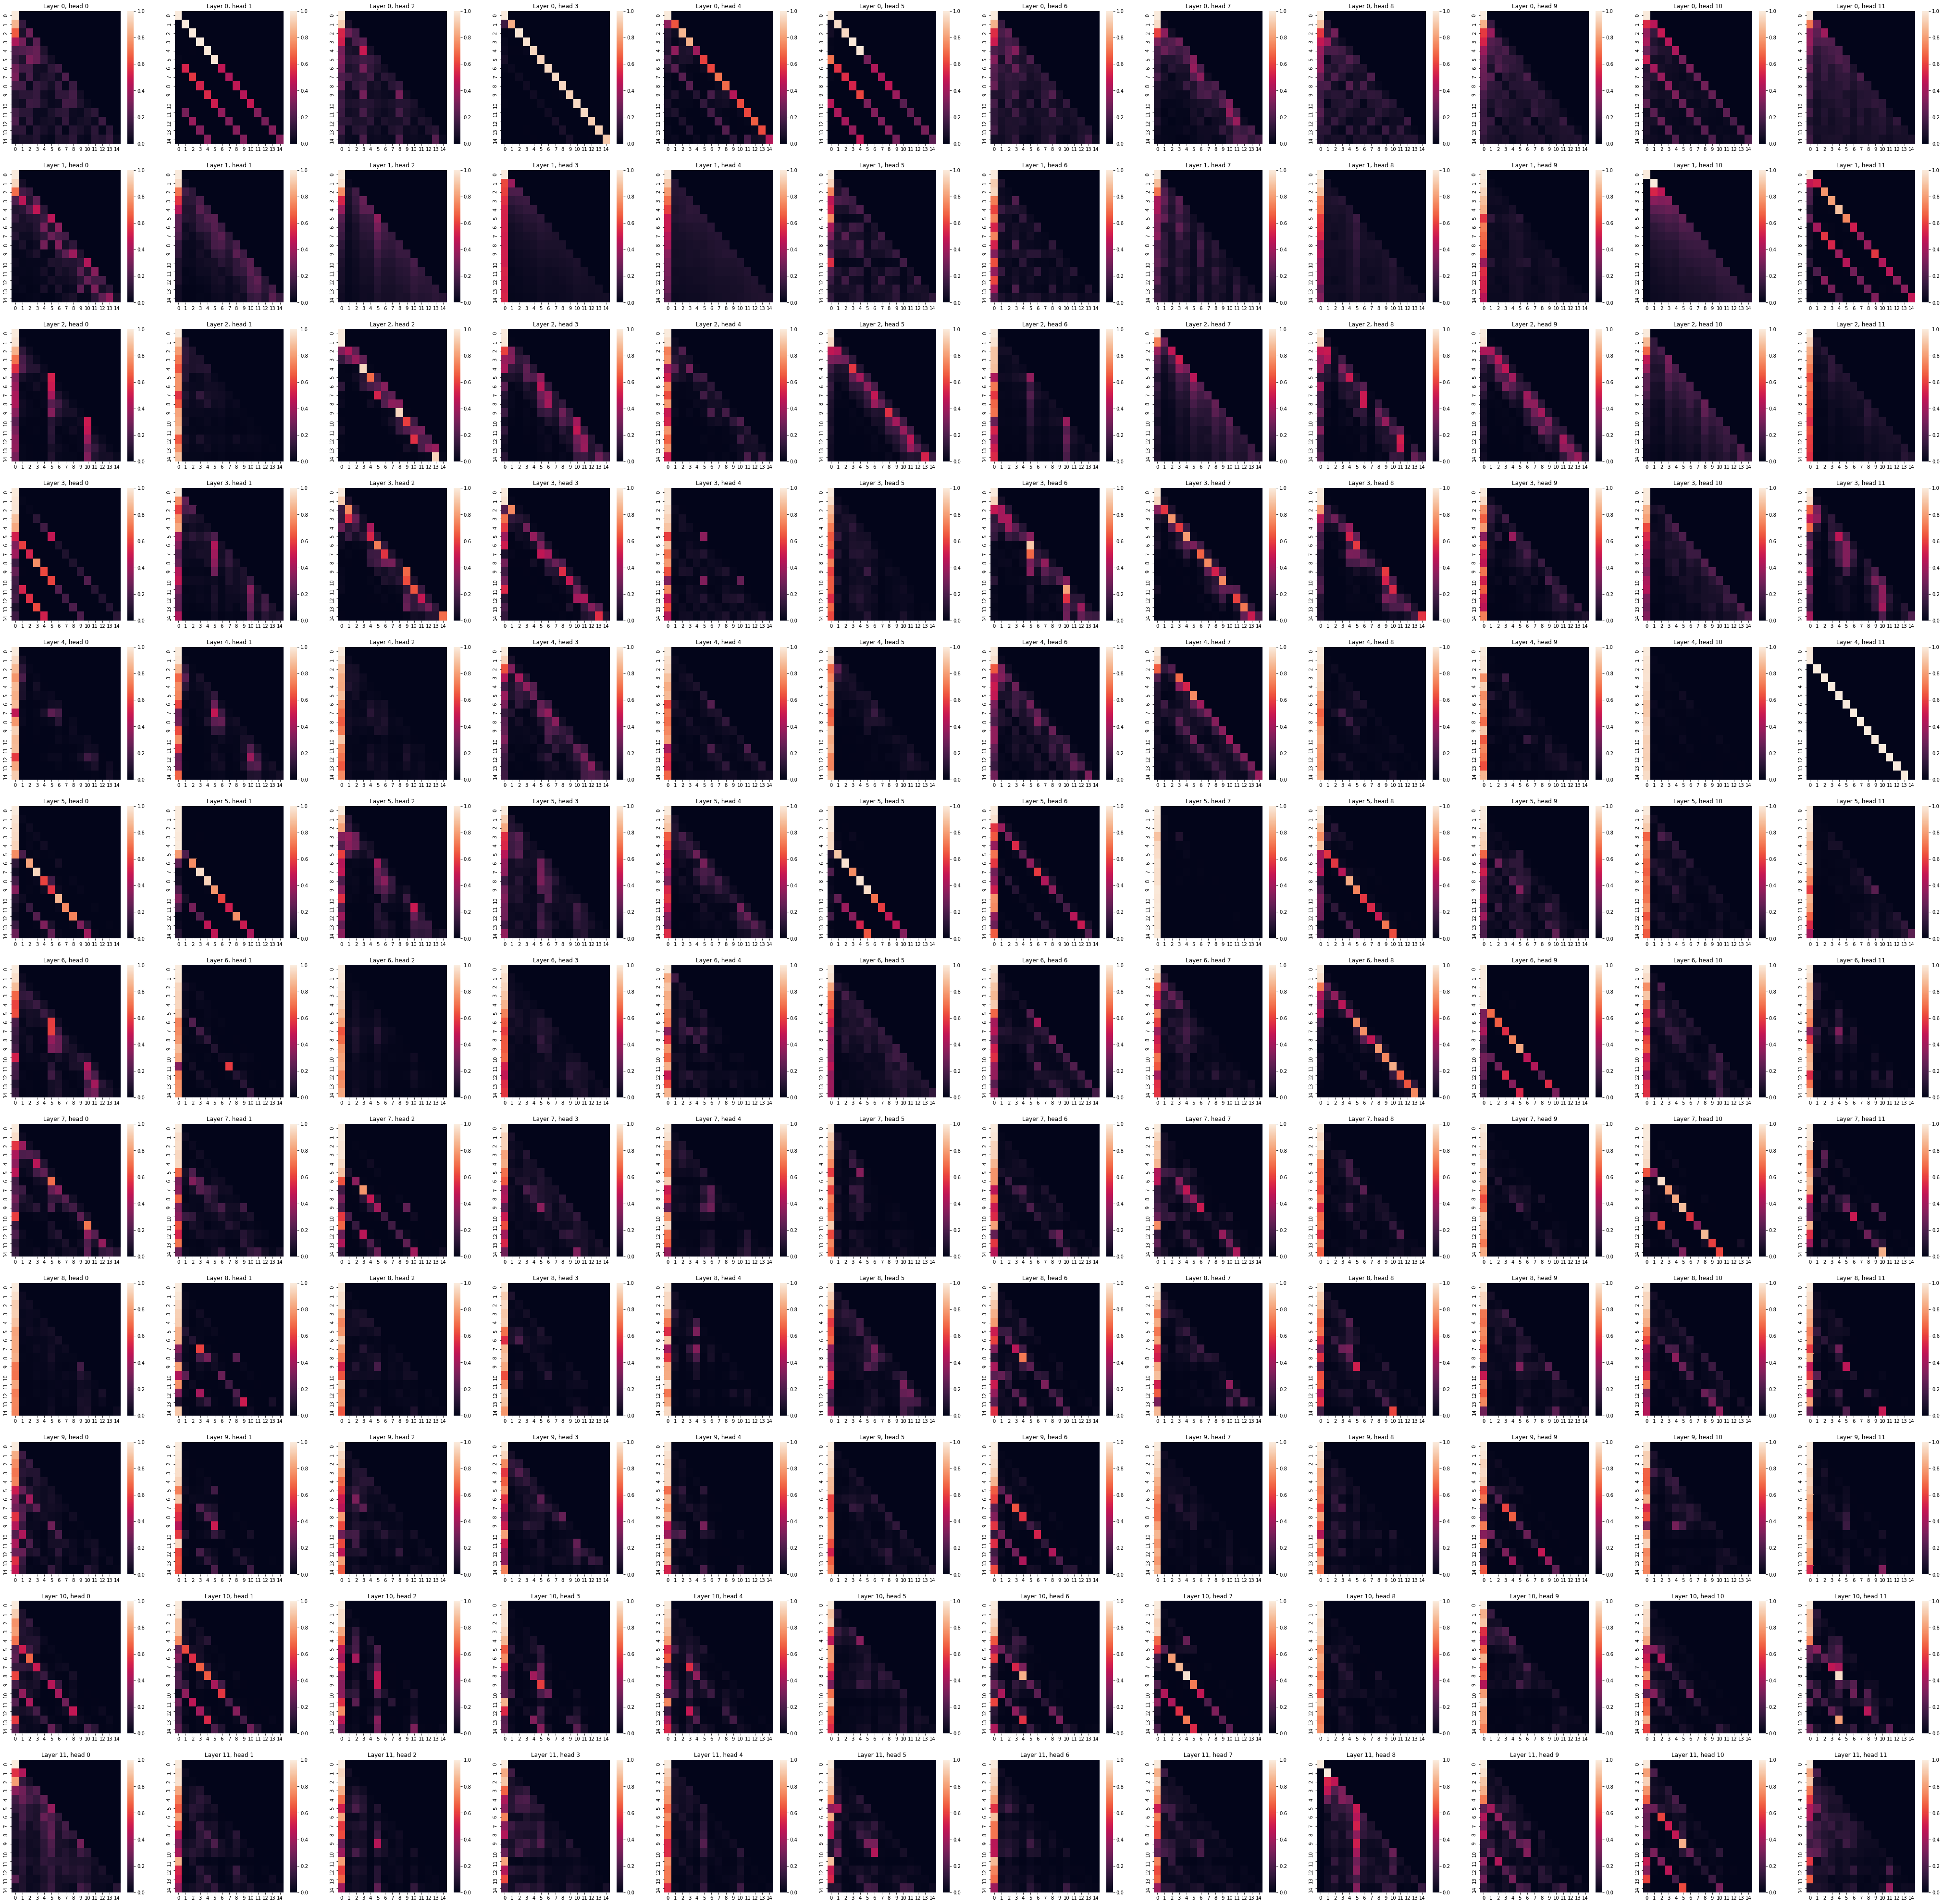

In [6]:
dir_name = 'simple_visz'
create_folder(dir_name)

fig, axs = plt.subplots(num_layer, num_heads, figsize=(num_heads*6,num_layer*6))
for layer in range(num_layer):
    for head in range(num_heads):
        sns.heatmap(attentions[layer, head], ax=axs[layer, head])
        axs[layer, head].set_title(f'Layer {layer}, head {head}')
plt.savefig(os.path.join(dir_name, f'attention_matrices'), bbox_inches='tight')

### Step 1-2-2: visualize the QK matrices

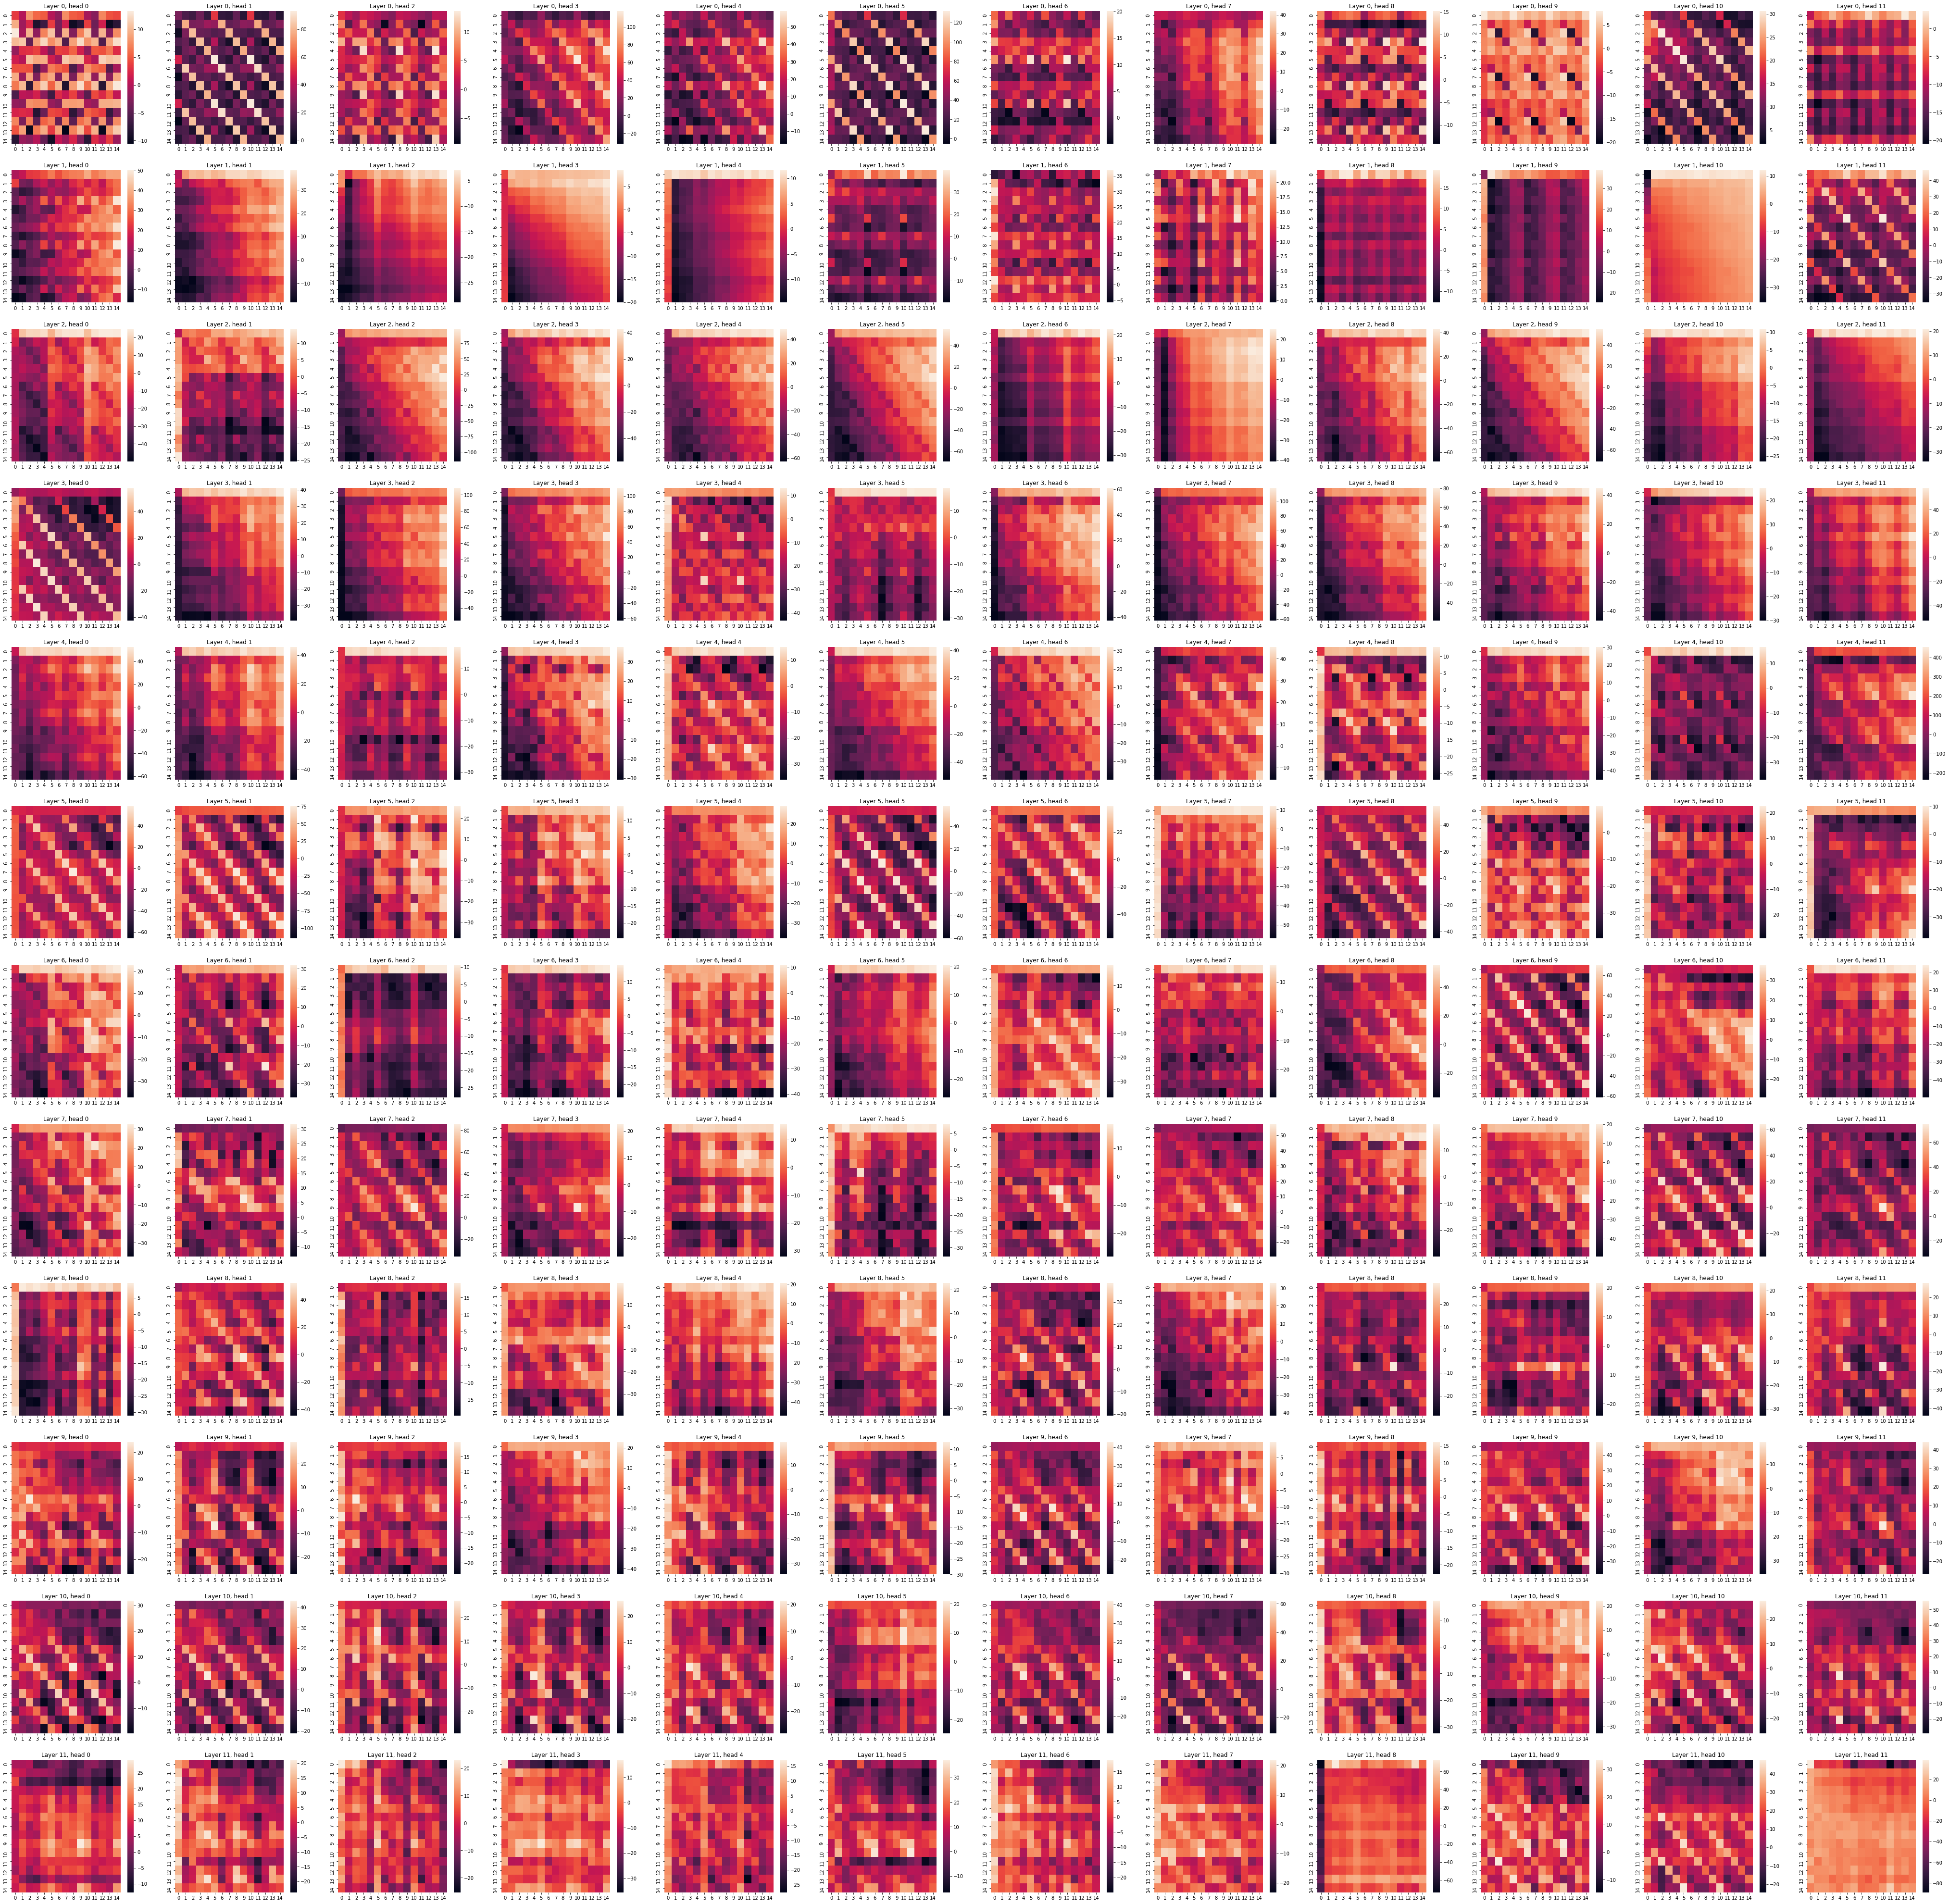

In [7]:
dir_name = 'simple_visz'
create_folder(dir_name)

fig, axs = plt.subplots(num_layer, num_heads, figsize=(num_heads*6,num_layer*6))
for layer in range(num_layer):
    for head in range(num_heads):
        W_qk = W_all[layer, head, 0] @ W_all[layer, head, 1].T
        QK = hiddens_all[layer, 1] @ W_qk @ hiddens_all[layer, 1].T
        sns.heatmap(QK.numpy(force=True), ax=axs[layer, head])
        axs[layer, head].set_title(f'Layer {layer}, head {head}')
plt.savefig(os.path.join(dir_name, f'QK_matrices'), bbox_inches='tight')

## Embeddings across layers

### Step 1-3-1: calculate cosine similarity between positions & layers

In [18]:
dir_name = 'embeddings'
create_folder(dir_name)
dir_name = 'embeddings/cos_similarity'
create_folder(dir_name)

sublayer_indices = [0, 1, 3, 4, 5]
scores = np.zeros((len(sublayer_indices), num_layer, num_layer))

for i, idx in tqdm(enumerate(sublayer_indices)):
    idx1, idx2 = idx, idx
    fig, axs = plt.subplots(num_layer, num_layer, figsize=(num_layer*6,num_layer*6))
    for layer1 in range(num_layer):
        for layer2 in range(num_layer):
            Gram = F.normalize(hiddens_all[layer1, idx1], dim=1) @ F.normalize(hiddens_all[layer2, idx2], dim=1).T
            Gram = Gram.numpy(force=True)
            scores[i, layer1, layer2] = np.mean(np.diag(Gram)[1:])
            sns.heatmap(Gram, ax=axs[layer1, layer2], cmap='bwr', vmin=-1, vmax=1)
    plt.savefig(os.path.join(dir_name, f'cosine_sim_layers_{layer1}_{layer2}_sublayer_idx_{idx}'), bbox_inches='tight')
    plt.close()

np.save('self_similarity', scores)

0it [00:00, ?it/s]

5it [25:48, 309.64s/it]


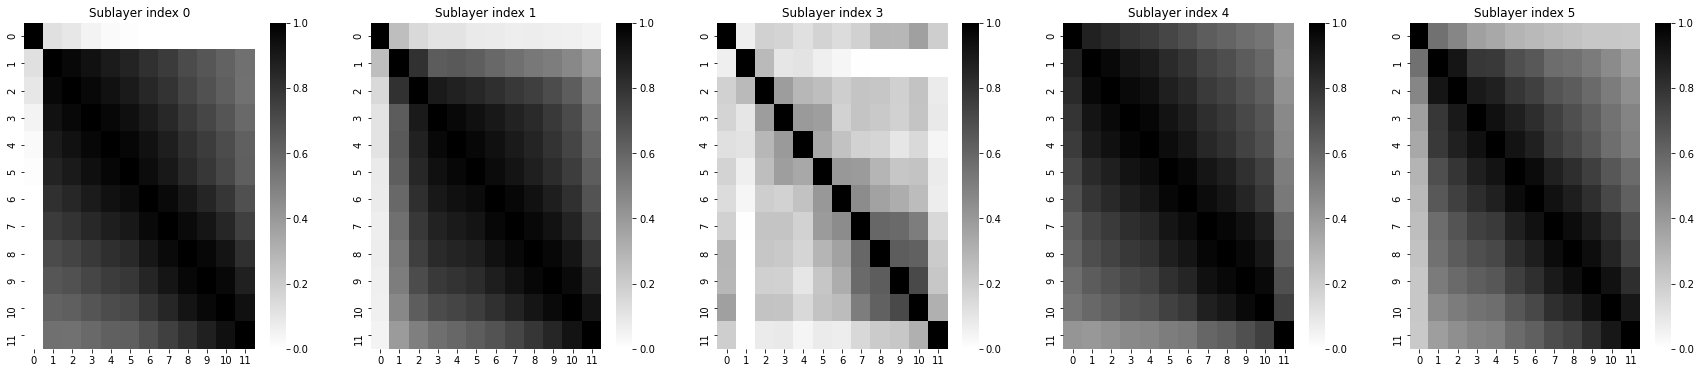

In [19]:
fig, axs = plt.subplots(1, len(sublayer_indices), figsize=(len(sublayer_indices)*6,1*6))

for i, idx in enumerate(sublayer_indices):
    sns.heatmap(scores[i], ax=axs[i], cmap='binary', vmin=0, vmax=1)
    axs[i].set_title(f'Sublayer index {idx}')
plt.savefig(os.path.join(dir_name, 'self_similarity'), bbox_inches='tight')

### Step 1-3-2: norm of embedding vectors

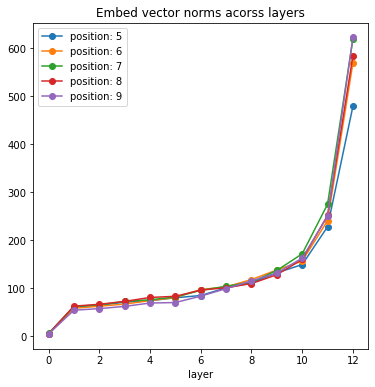

In [20]:
dir_name = 'embeddings'
create_folder(dir_name)

pos = [5,6,7,8,9]
vec_norms = np.zeros((num_layer+1, len(pos)))
for layer in range(num_layer+1):
    vec_norms[layer] = torch.norm(hiddens_all[layer,0][pos], dim=1).numpy(force=True)
    
fig, ax = plt.subplots(1,1,figsize=(6,6))
for j in range(len(pos)):
    ax.plot(np.arange(num_layer+1, dtype=int), vec_norms[:,j], '-o', label=f'position: {pos[j]}')
ax.set_xlabel('layer')
ax.set_title('Embed vector norms acorss layers')
ax.legend()
plt.savefig(os.path.join(dir_name, f'vector_norm'), bbox_inches='tight')


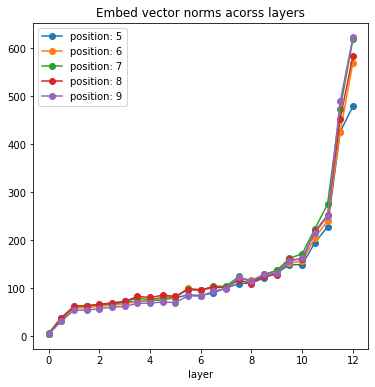

In [21]:
## showing norms from sublayer embeddings as well
dir_name = 'embeddings'
create_folder(dir_name)

pos = [5,6,7,8,9]
vec_norms = np.zeros((2*num_layer+1, len(pos)))
for layer in range(num_layer+1):
    vec_norms[2*layer] = torch.norm(hiddens_all[layer,0][pos], dim=1).numpy(force=True)
for layer in range(num_layer):
    vec_norms[2*layer+1] = torch.norm(hiddens_all[layer,4][pos], dim=1).numpy(force=True)
    
fig, ax = plt.subplots(1,1,figsize=(6,6))
for j in range(len(pos)):
    ax.plot(np.arange(2*num_layer+1)/2, vec_norms[:,j], '-o', label=f'position: {pos[j]}')
ax.set_xlabel('layer')
ax.set_title('Embed vector norms acorss layers')
ax.legend()
plt.savefig(os.path.join(dir_name, f'vector_norm_sublayer'), bbox_inches='tight')


### Step 1-3-3: inner products between embeddings and wte

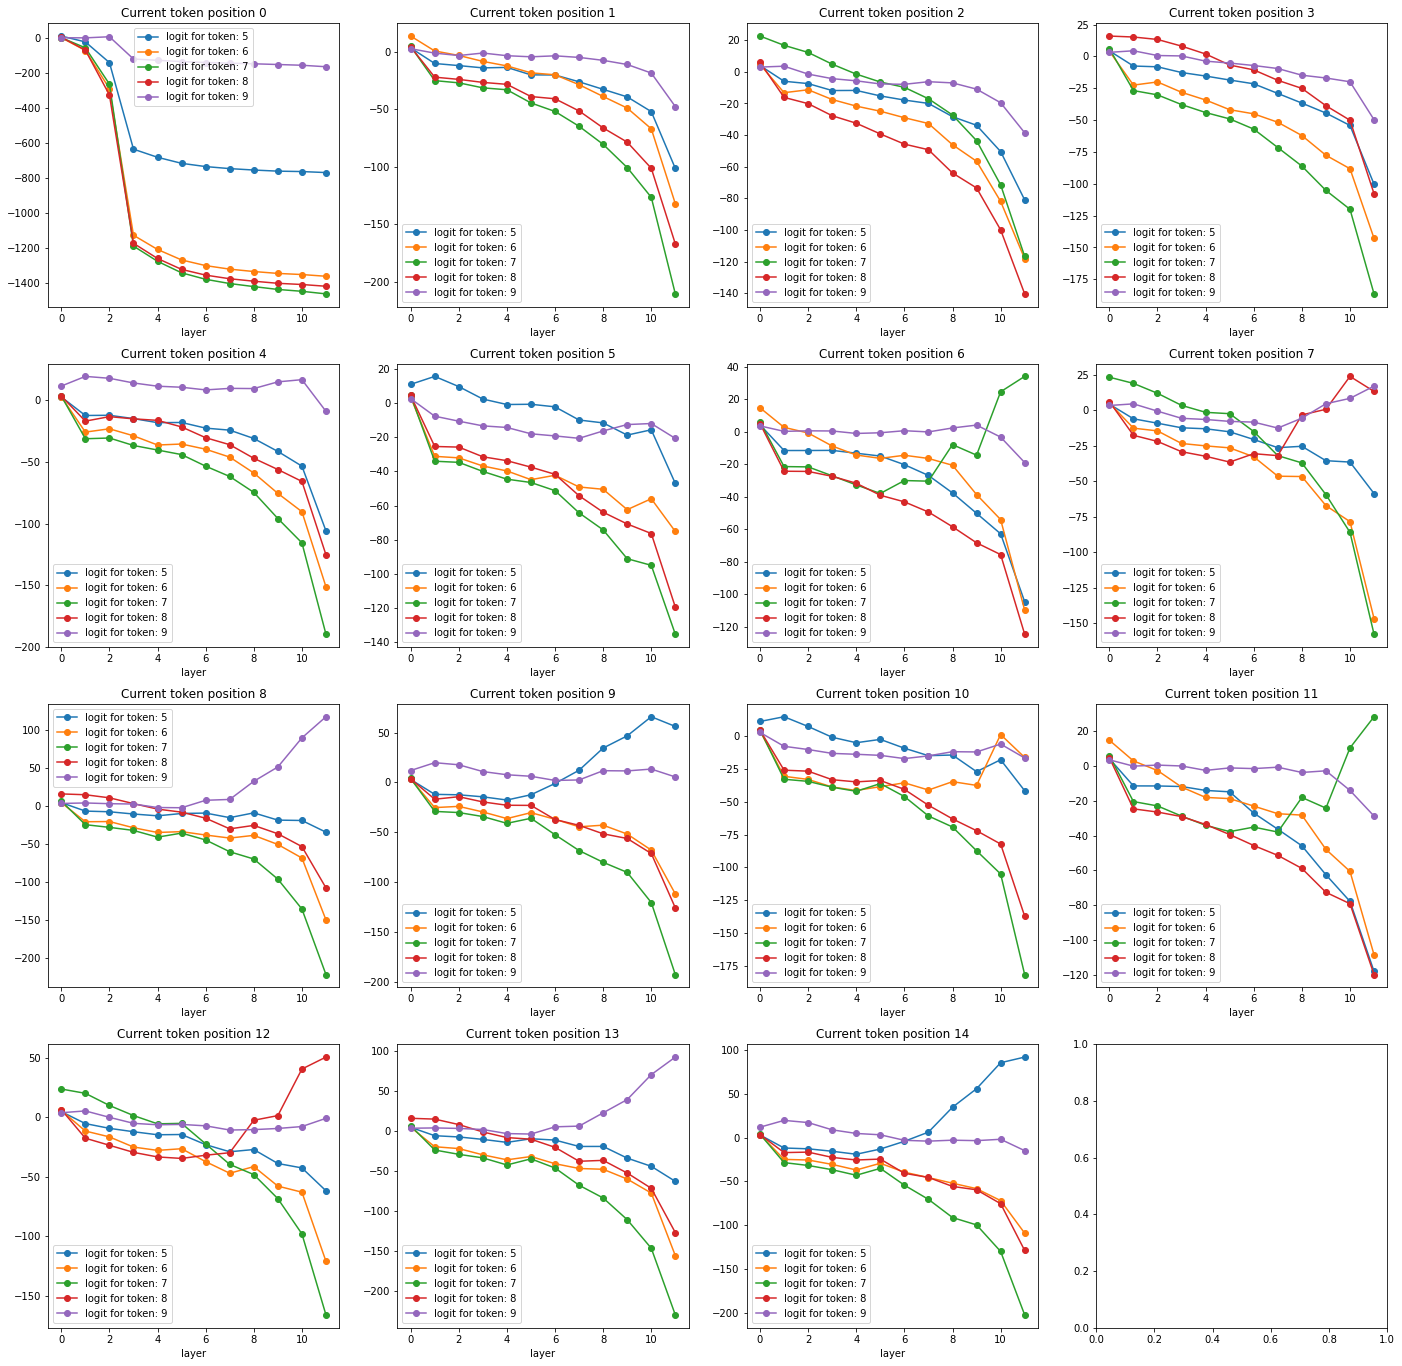

In [24]:
dir_name = 'embeddings'
create_folder(dir_name)

pos = [5,6,7,8,9]
scoring_vecs = W0[input_ids[0,pos],:].numpy(force=True)  # (len(pos), d_model)
scores = np.zeros((num_layer, seq_len, len(pos)))
for layer in range(num_layer):
    scores[layer] = hiddens_all[layer,0].numpy(force=True) @ scoring_vecs.T

num_row_subplots = int(np.ceil(np.sqrt(seq_len)))
fig, axs = plt.subplots(num_row_subplots, num_row_subplots,figsize=(6*num_row_subplots,6*num_row_subplots))
for t in range(seq_len):
    i, j = t//num_row_subplots, t%num_row_subplots
    for k in range(len(pos)):
        axs[i,j].plot(np.arange(num_layer, dtype=int), scores[:,t,k], '-o', label=f'logit for token: {pos[k]}')
        axs[i,j].set_xlabel('layer')
        axs[i,j].set_title(f'Current token position {t}')
        axs[i,j].legend()
plt.savefig(os.path.join(dir_name, f'prods_embed_wte'), bbox_inches='tight')

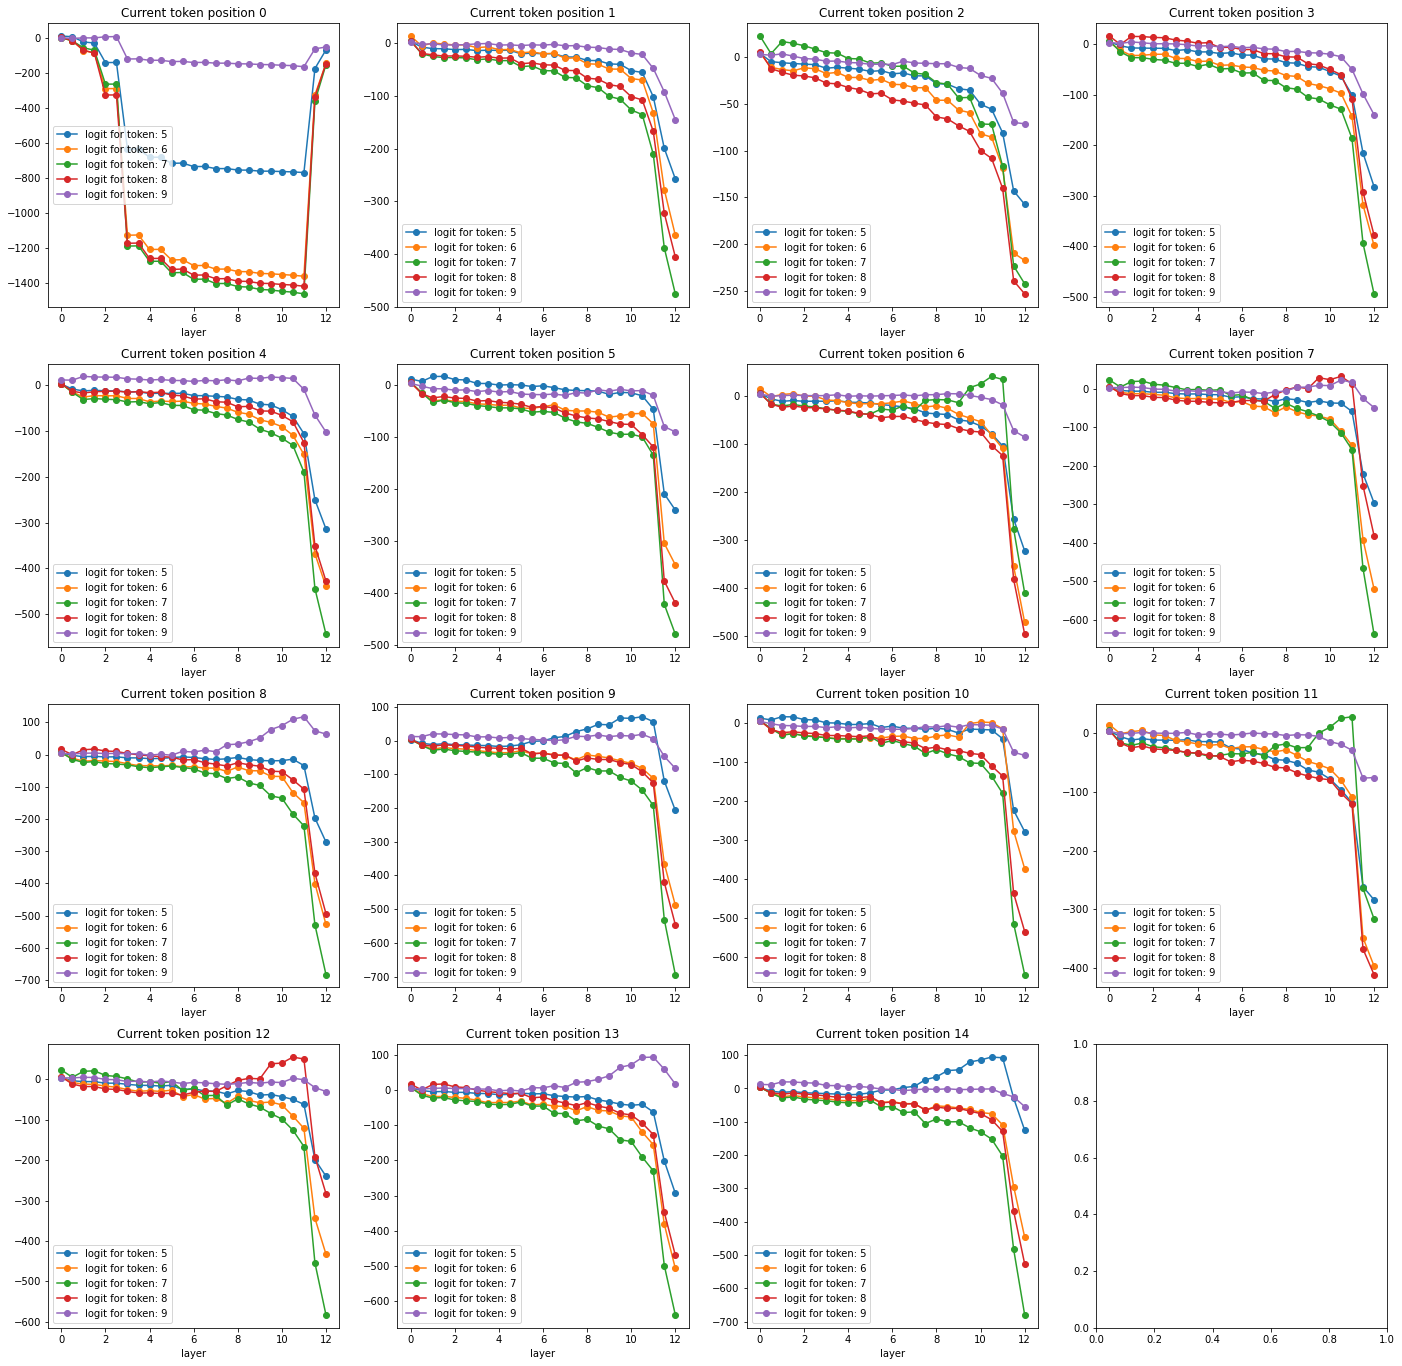

In [25]:
### show inner products for sublayer embeddings as well
dir_name = 'embeddings'
create_folder(dir_name)

pos = [5,6,7,8,9]
scoring_vecs = W0[input_ids[0,pos],:].numpy(force=True)  # (len(pos), d_model)
scores = np.zeros((2*num_layer+1, seq_len, len(pos)))
for layer in range(num_layer+1):
    scores[2*layer] = hiddens_all[layer,0].numpy(force=True) @ scoring_vecs.T
for layer in range(num_layer):
    scores[2*layer+1] = hiddens_all[layer,4].numpy(force=True) @ scoring_vecs.T

num_row_subplots = int(np.ceil(np.sqrt(seq_len)))
fig, axs = plt.subplots(num_row_subplots, num_row_subplots,figsize=(6*num_row_subplots,6*num_row_subplots))
for t in range(seq_len):
    i, j = t//num_row_subplots, t%num_row_subplots
    for k in range(len(pos)):
        axs[i,j].plot(np.arange(2*num_layer+1)/2, scores[:,t,k], '-o', label=f'logit for token: {pos[k]}')
        axs[i,j].set_xlabel('layer')
        axs[i,j].set_title(f'Current token position {t}')
        axs[i,j].legend()
plt.savefig(os.path.join(dir_name, f'prods_embed_wte_sublayer'), bbox_inches='tight')

### Step 1-3-4: Examine the top/bottom left singluar vectors of wte (over vocabulary)

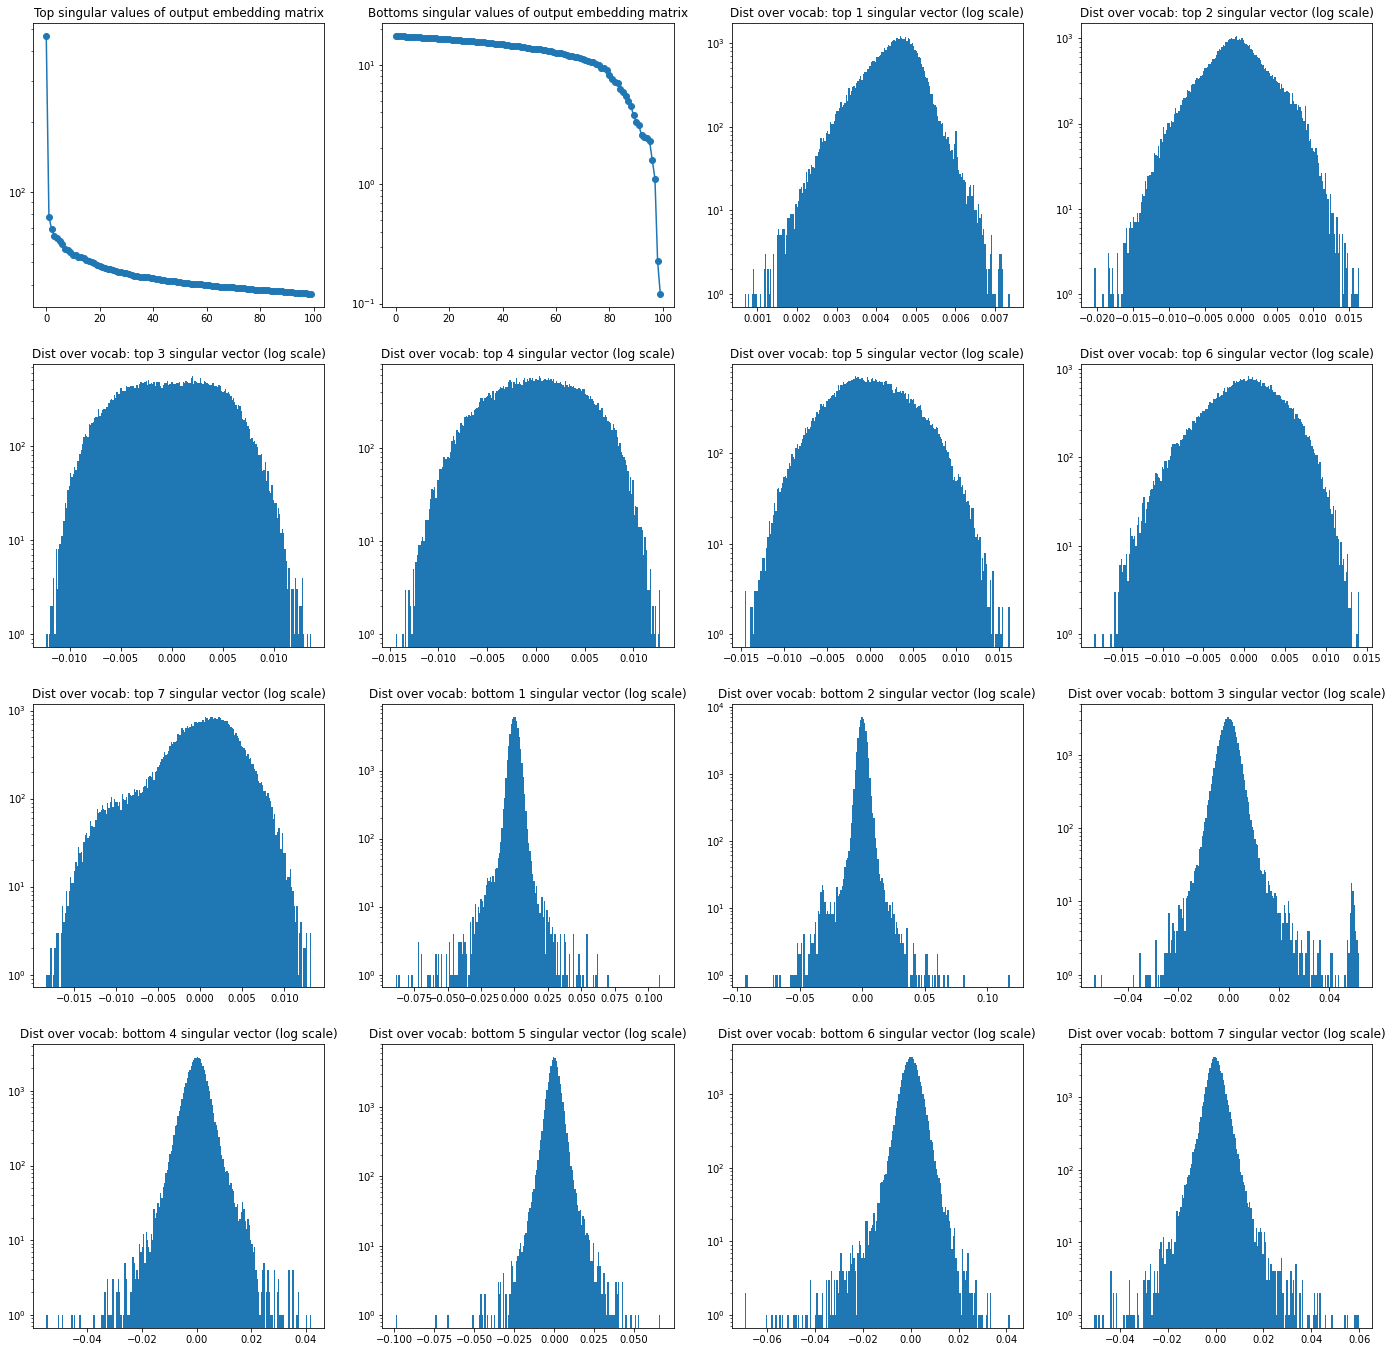

In [26]:
dir_name = 'embeddings'
create_folder(dir_name)

vecs_left = W0.numpy(force=True) @ vecs @ np.diag(1/np.sqrt(vals))

fig, axs = plt.subplots(4, 4, figsize=(6*4,6*4))
axs[0,0].plot(np.arange(100,dtype=int), np.sqrt(vals[:100]), '-o')
axs[0,0].set_title('Top singular values of output embedding matrix')
axs[0,0].set_yscale('log')
axs[0,1].plot(np.arange(100,dtype=int), np.sqrt(vals[-100:]), '-o')
axs[0,1].set_title('Bottoms singular values of output embedding matrix')
axs[0,1].set_yscale('log')
for j in range(2,9):
    axs[j//4,j%4].hist(vecs_left[:,j-2], 200)
    axs[j//4,j%4].set_title(f'Dist over vocab: top {j-1} singular vector (log scale)')
    axs[j//4,j%4].set_yscale('log')
for j in range(9,16):
    axs[j//4,j%4].hist(vecs_left[:,-j+8], 200)
    axs[j//4,j%4].set_title(f'Dist over vocab: bottom {j-8} singular vector (log scale)')
    axs[j//4,j%4].set_yscale('log')
plt.savefig(os.path.join(dir_name, f'svec_distribution_over_vocab'), bbox_inches='tight')

### 1-3-5: Does left singular vectors correspond to topics?

In [27]:
dir_name = 'embeddings'
create_folder(dir_name)
dir_name = 'embeddings/vocab_topics'
create_folder(dir_name)

for j in range(20):
    q0 = np.quantile(vecs_left[:,j], 0.001)
    q1 = np.quantile(vecs_left[:,j], 0.999) 

    filename = os.path.join(dir_name, f'top_svec_{j}.txt')
    select_tokens0 = tokenizer.convert_ids_to_tokens(np.where(vecs_left[:,j] < q0)[0]) 
    select_tokens1 = tokenizer.convert_ids_to_tokens(np.where(vecs_left[:,j] > q1)[0]) 
    with open(filename, 'a') as file:
        print(f'Examine outlying tokens for top svec {j}', file=file)
        print(f'Smallest values', file=file)
        print(f'----------------------------------', file=file)
        print(select_tokens0, file=file)
        print(f'----------------------------------', file=file)
        print(f'Largest values', file=file)
        print(f'----------------------------------', file=file)
        print(select_tokens1, file=file)


for j in range(20):
    q0 = np.quantile(vecs_left[:,-j], 0.001)
    q1 = np.quantile(vecs_left[:,-j], 0.999) 

    filename = os.path.join(dir_name, f'bottom_svec_{j}.txt')
    select_tokens0 = tokenizer.convert_ids_to_tokens(np.where(vecs_left[:,-j] < q0)[0]) 
    select_tokens1 = tokenizer.convert_ids_to_tokens(np.where(vecs_left[:,-j] > q1)[0]) 
    with open(filename, 'a') as file:
        print(f'Examine outlying tokens for bottom svec {j}', file=file)
        print(f'Smallest values', file=file)
        print(f'----------------------------------', file=file)
        print(select_tokens0, file=file)
        print(f'----------------------------------', file=file)
        print(f'Largest values', file=file)
        print(f'----------------------------------', file=file)
        print(select_tokens1, file=file)


## Matching weight matrices

### Step 2-0: Measuring induction head (ranking most likely induction head to most unlikely)

In [53]:
dir_name = 'simple_visz'
create_folder(dir_name)
filename = os.path.join(dir_name, f'induction_head_scores.txt')

scores = np.zeros((num_layer, num_heads))
for layer in range(num_layer):
    for head in range(num_heads):
        A = attentions[layer, head]
        A_adjusted = np.zeros((seq_len, seq_len))
        A_adjusted[1:, 1:] = A[1:, 1:] / np.sum(A[1:, 1:], axis=1, keepdims=True)
        diag1 = np.diag(A_adjusted, -(T0-1))[1:]
        diag2 = np.diag(A_adjusted, -(2*T0-1))[1:]
        diag = np.concatenate((diag1[:-T0], diag1[-T0:] + diag2))
        scores[layer, head] = np.mean(diag)
        
idx_sort = np.argsort(scores, axis=None)[::-1]
IH_list = [[idx_sort[j] // num_heads, idx_sort[j] % num_heads] for j in range(len(idx_sort))]

with open(filename, 'w') as file:
    print(f'Ranking induction heads (most likely to unlikely) by attention scores', file=file)
    for j, pair in enumerate(IH_list):
        layer, head = pair[0], pair[1]
        print(f'Layer {layer} Head {head}: score {scores[layer, head]}', file=file)
        if j <= 20:
            print(f'Layer {layer} Head {head}: score {scores[layer, head]}')

Layer 5 Head 1: score 0.9953718118369579
Layer 5 Head 5: score 0.990281829237938
Layer 6 Head 9: score 0.9886472076177597
Layer 7 Head 10: score 0.9395123064517975
Layer 5 Head 8: score 0.9212846681475639
Layer 10 Head 7: score 0.9204489514231682
Layer 5 Head 0: score 0.8876477140933275
Layer 7 Head 2: score 0.8102711588144302
Layer 10 Head 1: score 0.8059151142835617
Layer 9 Head 9: score 0.7934778571128845
Layer 9 Head 6: score 0.7573517456650734
Layer 11 Head 10: score 0.7551812022924423
Layer 6 Head 1: score 0.6811700388789177
Layer 10 Head 6: score 0.6629793018102645
Layer 8 Head 1: score 0.6548116706311703
Layer 10 Head 0: score 0.6461946688592434
Layer 7 Head 11: score 0.6174160994589328
Layer 8 Head 6: score 0.598575821518898
Layer 10 Head 10: score 0.5727810949087143
Layer 8 Head 11: score 0.5598440669476986
Layer 9 Head 1: score 0.52265305519104


### Matching QK and OV

### Step 2-1: for a likely induction head QK, examine and try to match OV from previous layer/head
**Caution: this code block is slow (seaborn heatmap bad)**

In [65]:
dir_name = 'W_qkov_visz'
create_folder(dir_name)
num_top = 100
filename = os.path.join(dir_name, f'qkov_scores.txt')

match_scores_all = []
match_list_all = []

for i, (Layer, Head) in enumerate(IH_list[:20]):
    print(f'Generating plots...Layer {Layer} Head {Head}')
    match_scores = np.zeros((Layer, num_heads, 5))

    W_qk = W_all[Layer, Head, 0] @ W_all[Layer, Head, 1].T
    W_qk_diag = torch.diag(torch.diag(W_qk))
    W_qk_diag_rm = W_qk - torch.diag(torch.diag(W_qk))

    fig, axs = plt.subplots(Layer, num_heads, figsize=(num_heads*6,Layer*6))
    for layer in range(Layer):
        print(f'Mactching OV...Layer: {layer}')
        for head in range(num_heads): 
            W_ov = W_all[layer, head, 3] @ W_all[layer, head, 2].T
            W_ov_diag = torch.diag(torch.diag(W_ov))
            W_ov_diag_rm = W_ov - torch.diag(torch.diag(W_ov))
            sns.heatmap((W_qk @ W_ov).numpy(force=True)[:num_top, :num_top], ax=axs[layer, head])
            axs[layer, head].set_title(f'Layer {layer}, Head {head}')
            match_scores[layer, head, 0] = np.mean(np.diag((W_qk @ W_ov).numpy(force=True)))
            match_scores[layer, head, 1] = np.mean(np.diag((W_qk_diag @ W_ov_diag).numpy(force=True)))
            match_scores[layer, head, 2] = np.mean(np.diag((W_qk_diag_rm @ W_ov_diag).numpy(force=True)))
            match_scores[layer, head, 3] = np.mean(np.diag((W_qk_diag @ W_ov_diag_rm).numpy(force=True)))
            match_scores[layer, head, 4] = np.mean(np.diag((W_qk_diag_rm @ W_ov_diag_rm).numpy(force=True)))
    plt.savefig(os.path.join(dir_name, f'W_qkov_Layer_{Layer}_Head_{Head}'), bbox_inches='tight')
    plt.close()

    idx_sort = np.argsort(match_scores[:, :, 0], axis=None)[::-1]
    match_list = [[idx_sort[j] // num_heads, idx_sort[j] % num_heads] for j in range(len(idx_sort))]
    match_scores_all.append(match_scores)
    match_list_all.append(match_list)
    with open(filename, 'a') as file:
        print(f'------------------------------------------', file=file)
        print(f'Ranking by mean diagonal of qkov matrix for QK pair Layer {Layer} Head {Head}. Top scores', file=file)
        for j, pair in enumerate(match_list):
            print(f'Layer {pair[0]} Head {pair[1]} score {match_scores[pair[0], pair[1], 0]:.3f}', file=file)
        print(f'Mean diagonal of qkov matrix ; Examine each ov components from previous layer/head', file=file)
        for layer in range(Layer):
            for head in range(head):
                print(f'Layer {layer} Head {head}: score {match_scores[layer, head, 0]:.3f}', file=file)
                print(f'Component scores {match_scores[layer, head, 1]:.3f} {match_scores[layer, head, 2]:.3f} {match_scores[layer, head, 3]:.3f} {match_scores[layer, head, 4]:.3f}', file=file)

np.save('match_scores', match_scores_all)
np.save('match_list', match_list_all)


Generating plots...Layer 5 Head 1
Mactching OV...Layer: 0
Mactching OV...Layer: 1
Mactching OV...Layer: 2
Mactching OV...Layer: 3
Mactching OV...Layer: 4
Generating plots...Layer 5 Head 5
Mactching OV...Layer: 0
Mactching OV...Layer: 1
Mactching OV...Layer: 2
Mactching OV...Layer: 3
Mactching OV...Layer: 4
Generating plots...Layer 6 Head 9
Mactching OV...Layer: 0
Mactching OV...Layer: 1
Mactching OV...Layer: 2
Mactching OV...Layer: 3
Mactching OV...Layer: 4
Mactching OV...Layer: 5
Generating plots...Layer 7 Head 10
Mactching OV...Layer: 0
Mactching OV...Layer: 1
Mactching OV...Layer: 2
Mactching OV...Layer: 3
Mactching OV...Layer: 4
Mactching OV...Layer: 5
Mactching OV...Layer: 6
Generating plots...Layer 5 Head 8
Mactching OV...Layer: 0
Mactching OV...Layer: 1
Mactching OV...Layer: 2
Mactching OV...Layer: 3
Mactching OV...Layer: 4
Generating plots...Layer 10 Head 7
Mactching OV...Layer: 0
Mactching OV...Layer: 1
Mactching OV...Layer: 2
Mactching OV...Layer: 3
Mactching OV...Layer: 4
Ma

/Users/yiqiaoz/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


### Step 2-2: maching the subspace of QK and OV

In [68]:
dir_name = 'W_qkov_subspace_visz'
create_folder(dir_name)
num_svals_plot = 50

for i, (Layer, Head) in tqdm(enumerate(IH_list[:10])):
    match_list = match_list_all[i]

    W_qk = W_all[Layer, Head, 0] @ W_all[Layer, Head, 1].T
    U_qk, s_qk, Vt_qk = np.linalg.svd(W_qk.numpy(force=True))

    fig, axs = plt.subplots(Layer, num_heads, figsize=(num_heads*6,Layer*6))

    for layer in range(Layer):
        for head in range(num_heads): 
            W_ov = W_all[layer, head, 3] @ W_all[layer, head, 2].T
            U_ov, s_ov, Vt_ov = np.linalg.svd(W_ov.numpy(force=True))
            s_match = np.zeros(num_svals_plot)
            for j in range(num_svals_plot):
                _, s, _ = np.linalg.svd(Vt_qk[:(j+1),:] @ U_ov[:,:(j+1)])
                s_match[j] = s[0]
            label_qk = 'qk' if layer == 0 and head == 0 else None
            label_ov = 'ov' if layer == 0 and head == 0 else None
            label_match = 'match' if layer == 0 and head == 0 else None
            color = 'red' if [layer, head] in match_list[:5] else 'black'

            axs[layer, head].plot(s_qk[:num_svals_plot]/s_qk[0], label=label_qk, linewidth=2)
            axs[layer, head].plot(s_ov[:num_svals_plot]/s_ov[0], label=label_ov, linewidth=2)
            axs[layer, head].plot(s_match[:num_svals_plot], label=label_match)
            axs[layer, head].set_title(f'Layer {layer} Head {head}', color=color, weight='bold')
            if layer == 0 and head == 0:
                axs[layer, head].legend()
    plt.savefig(os.path.join(dir_name, f'singular_match_L_{Layer}_H_{Head}'), bbox_inches='tight')
    plt.close()

    fig, axs = plt.subplots(Layer, num_heads, figsize=(num_heads*6,Layer*6))
    for layer in range(Layer):
        for head in range(num_heads): 
            W_ov = W_all[layer, head, 3] @ W_all[layer, head, 2].T
            U_ov, s_ov, Vt_ov = np.linalg.svd(W_ov.numpy(force=True))
            s_match = np.zeros(num_svals_plot)
            for j in range(num_svals_plot):
                _, s, _ = np.linalg.svd(Vt_ov[:(j+1),:] @ U_qk[:,:(j+1)])
                s_match[j] = s[0]
            label_qk = 'qk' if layer == 0 and head == 0 else None
            label_ov = 'ov' if layer == 0 and head == 0 else None
            label_match = 'match' if layer == 0 and head == 0 else None
            color = 'red' if [layer, head] in match_list[:5] else 'black'
            
            axs[layer, head].plot(s_qk[:num_svals_plot]/s_qk[0], label=label_qk, linewidth=2)
            axs[layer, head].plot(s_ov[:num_svals_plot]/s_ov[0], label=label_ov, linewidth=2)
            axs[layer, head].plot(s_match[:num_svals_plot], label=label_match)
            axs[layer, head].set_title(f'Layer {layer} Head {head}', color=color, weight='bold')
            if layer == 0 and head == 0:
                axs[layer, head].legend()
    plt.savefig(os.path.join(dir_name, f'singular_match_outer_L_{Layer}_H_{Head}'), bbox_inches='tight')
    plt.close()


10it [07:00, 42.04s/it]


### Step 2-3: inner products between query embedding and key subupdates

In [73]:
dir_name = 'W_query_subupdates'
create_folder(dir_name)

for i, (Layer, Head) in tqdm(enumerate(IH_list[:10])):
    match_list = match_list_all[i]

    query_embed = hiddens_all[Layer, 0][-1]
    W_qk = W_all[Layer, Head, 0] @ W_all[Layer, Head, 1].T

    fig, axs = plt.subplots(Layer, num_heads, figsize=(num_heads*6,Layer*6))
    for layer in range(Layer):
        key_embed = hiddens_all[layer, 1]
        for head in range(num_heads): 
            W_ov = W_all[layer, head, 3] @ W_all[layer, head, 2].T
            key_embed_weighted = torch.tensor(attentions[layer, head]) @ key_embed
            updates = W_qk @ W_ov @ key_embed_weighted.T
            prods = (updates.T @ query_embed.view(d_model,1)).squeeze().numpy(force=True) # (T,)
            color = 'red' if [layer, head] in match_list[:5] else 'black'

            axs[layer, head].scatter(np.arange(seq_len, dtype=int), prods)
            axs[layer, head].set_title(f'Layer: {layer}, Head: {head}', color=color, weight='bold')
            if [layer, head] in match_list[:5]:
                axs[layer, head].vlines(T0, np.min(prods), np.max(prods), linestyles='dashed', colors='red')
                axs[layer, head].vlines(2*T0, np.min(prods), np.max(prods), linestyles='dashed', colors='red')
    plt.savefig(os.path.join(dir_name, f'update_query_prod_L_{Layer}_H_{Head}'), bbox_inches='tight')
    plt.close()


10it [01:17,  7.77s/it]


### Step 2-3-2: inner products between query embedding and key subupdates (without QK this time)

In [75]:
dir_name = 'W_query_subupdates'
create_folder(dir_name)

for i, (Layer, Head) in tqdm(enumerate(IH_list[:10])):
    match_list = match_list_all[i]

    query_embed = hiddens_all[Layer, 0][-1]
    W_qk = W_all[Layer, Head, 0] @ W_all[Layer, Head, 1].T

    fig, axs = plt.subplots(Layer, num_heads, figsize=(num_heads*6,Layer*6))
    for layer in range(Layer):
        key_embed = hiddens_all[layer, 1]
        for head in range(num_heads): 
            W_ov = W_all[layer, head, 3] @ W_all[layer, head, 2].T
            key_embed_weighted = torch.tensor(attentions[layer, head]) @ key_embed
            updates = W_ov @ key_embed_weighted.T
            prods = (updates.T @ query_embed.view(d_model,1)).squeeze().numpy(force=True) # (T,)
            color = 'red' if [layer, head] in match_list[:5] else 'black'

            axs[layer, head].scatter(np.arange(seq_len, dtype=int), prods)
            axs[layer, head].set_title(f'Layer: {layer}, Head: {head}', color=color, weight='bold')
            if [layer, head] in match_list[:5]:
                axs[layer, head].vlines(T0, np.min(prods), np.max(prods), linestyles='dashed', colors='red')
                axs[layer, head].vlines(2*T0, np.min(prods), np.max(prods), linestyles='dashed', colors='red')
    plt.savefig(os.path.join(dir_name, f'update_query_prod_cmp_L_{Layer}_H_{Head}'), bbox_inches='tight')
    plt.close()

10it [01:08,  6.85s/it]


### QK subspace universality

100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


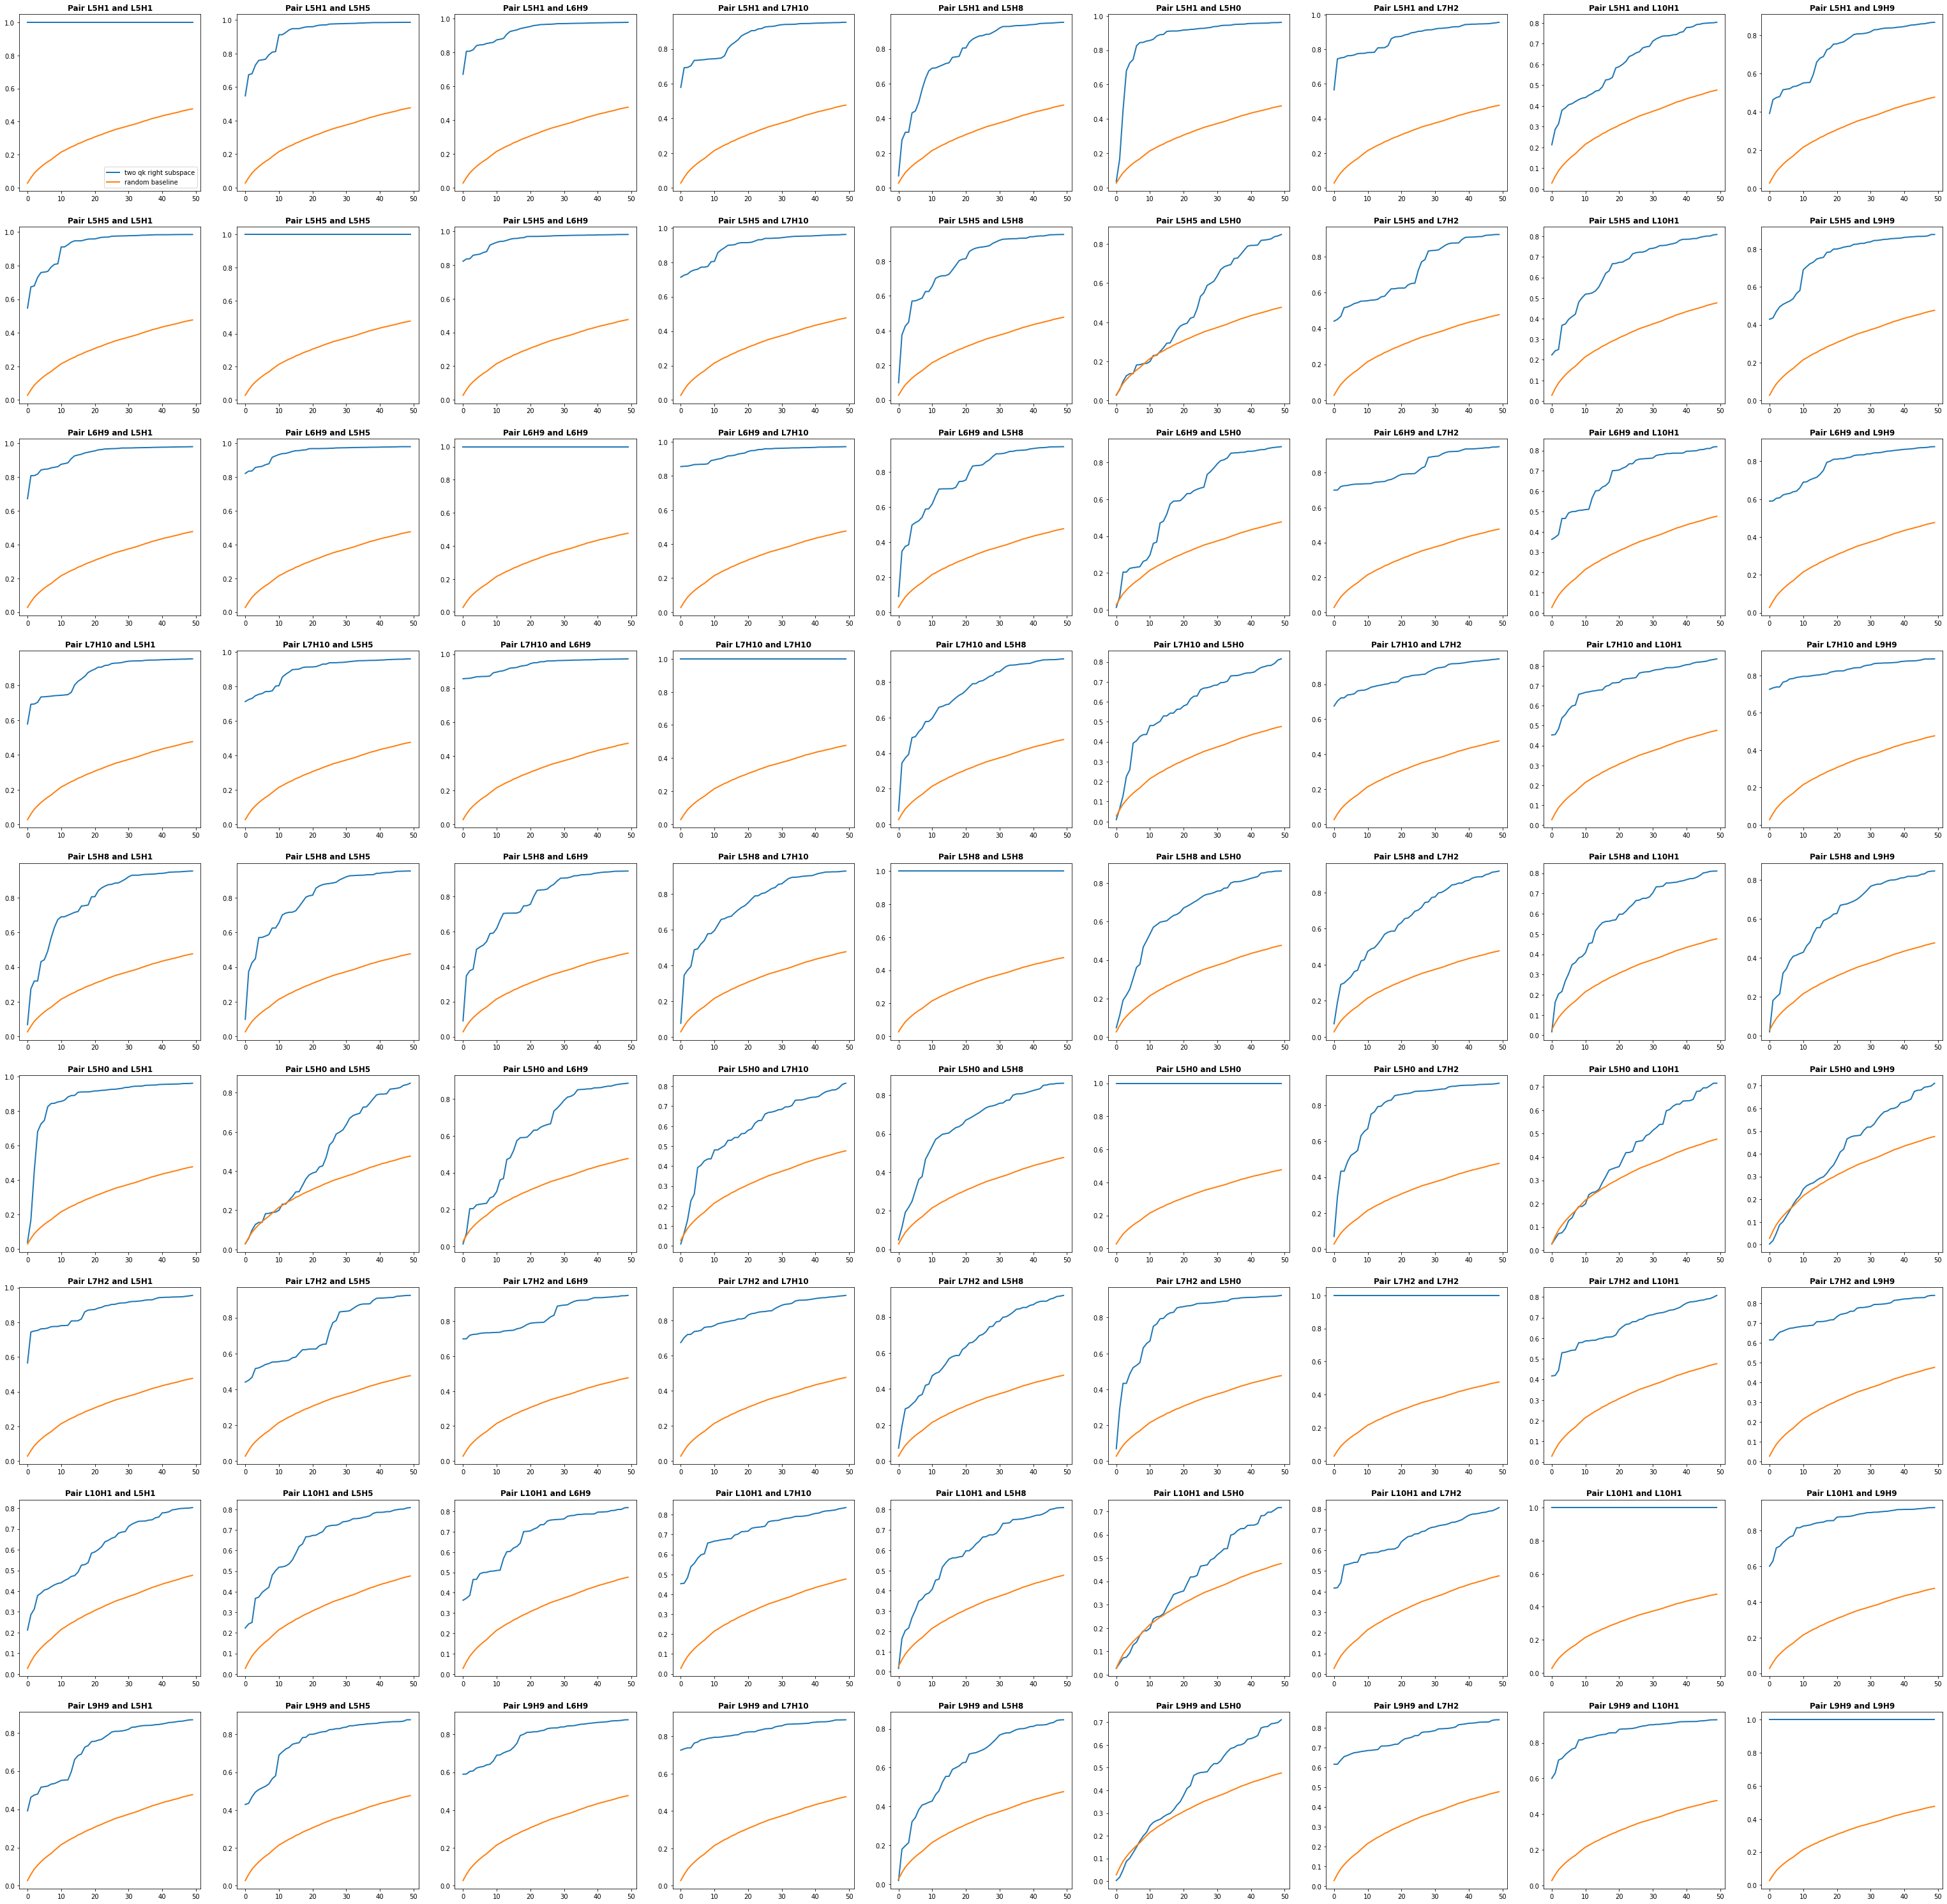

In [82]:
dir_name = 'QK_universality'
create_folder(dir_name)
num_svals_plot = 50
num_IH = 10 # number of pairwise Induction Head to match
num_samp = 50 # for random baseline

LayerHeadPair = IH_list[:num_IH]
LayerHeadPair.pop(5) # visual inspection suggests that one is not really a good induction head, so remove
num_IH = len(LayerHeadPair)

match_baseline = np.zeros((num_samp, num_svals_plot))
for i in tqdm(range(num_samp)):
    mat1 = np.random.randn(d_model, d_head) @ np.random.randn(d_head, d_model)
    mat2 = np.random.randn(d_model, d_head) @ np.random.randn(d_head, d_model)
    U1, s1, Vt1 = np.linalg.svd(mat1)
    U2, s2, Vt2 = np.linalg.svd(mat2)
    for j in range(num_svals_plot):
        _, s_match_u, _ = np.linalg.svd(Vt1[:(j+1),:] @ Vt2[:(j+1),:].T)
        match_baseline[i, j] = s_match_u[0]

fig, axs = plt.subplots(num_IH, num_IH, figsize=(num_IH*6, num_IH*6))
for i0 in range(len(LayerHeadPair)):
    for i1 in range(len(LayerHeadPair)):
        Layer0, Head0 = LayerHeadPair[i0][0], LayerHeadPair[i0][1]
        Layer1, Head1 = LayerHeadPair[i1][0], LayerHeadPair[i1][1]
        W_qk0 = W_all[Layer0, Head0, 0] @ W_all[Layer0, Head0, 1].T
        W_qk1 = W_all[Layer1, Head1, 0] @ W_all[Layer1, Head1, 1].T
        U_qk0, s_qk0, Vt_qk0 = np.linalg.svd(W_qk0.numpy(force=True))
        U_qk1, s_qk1, Vt_qk1 = np.linalg.svd(W_qk1.numpy(force=True))

        s_match = np.zeros(num_svals_plot)
        for j in range(num_svals_plot):
            _, s, _ = np.linalg.svd(Vt_qk0[:(j+1),:] @ Vt_qk1[:(j+1),:].T)
            s_match[j] = s[0]
        axs[i0,i1].plot(s_match, linewidth=2, label='two qk right subspace')
        axs[i0,i1].plot(np.mean(match_baseline, 0), linewidth=2, label='random baseline')
        axs[i0,i1].set_title(f'Pair L{Layer0}H{Head0} and L{Layer1}H{Head1}', weight='bold')
        if i0 == 0 and i1 == 0:
            axs[i0,i1].legend()

plt.savefig(os.path.join(dir_name, f'QK_subspace_match_rm_one'), bbox_inches='tight')

